In [1]:
%run key_imports.py

In [ ]:
"""
Fix Random Seed
"""
SEED = 42
rng = default_rng(SEED)

"""
Fix Terminal maturity
"""

T = 1
N_TIMES = 16
dt = T / N_TIMES
ts = np.linspace(dt, T, N_TIMES)

"""
Define State Variables
"""
N_SAMPLES = 100
SK = rng.uniform(0.4, 5, N_SAMPLES).reshape((-1, 1))
rho = rng.uniform(-0.5, 0.0, N_SAMPLES).reshape((-1, 1))
kappa = rng.uniform(0, 2, N_SAMPLES)
vbar = rng.uniform(0, 0.5, N_SAMPLES)
vol_of_vol = rng.uniform(0, 0.5, N_SAMPLES)
V0 = vbar


"""
Define Brownian Increments
"""
W_v = rng.standard_normal((N_SAMPLES, N_TIMES)) * np.sqrt(dt)
W_s = rng.standard_normal((N_SAMPLES, N_TIMES)) * np.sqrt(dt)


"""
Simulate St, Vt paths
"""
Sts = np.zeros((N_SAMPLES, N_TIMES))
Vts = np.zeros((N_SAMPLES, N_TIMES))

Vts[:,0] = cir_step(V0, kappa, vbar, dt, vol_of_vol, W_v[:,0])
Sts[:, 0] = heston_step(S0, dt, V0, W_s[:,0], W_v[:,0], rho)
for i in range(1, N_TIMES):
    Vts[:, i] = cir_step(Vts[:, i - 1], kappa, vbar, dt, vol_of_vol, W_v[:, i])
    Sts[:, i] = heston_step(Sts[:,i-1], dt, V0, W_s[:,i], W_v[:, i], rho)

    
# np.repeat(ts, N_SAMPLES).reshape((-1, N_SAMPLES)).T.reshape(-1)
# np.repeat(kappa, N_TIMES)

"""
Combine to create dataset
"""

feat_names = ['S/K', 'V','ttm', 'kappa', 'rho', 'vbar','vol_of_vol']

f_to_i = lambda x: feat_names.index(x)

K = (Sts[:, -1] / SK[:,0]).reshape((-1, 1))
y = np.maximum((Sts[:,-1] / K[:,0]) - 1, 0)
Xs = np.vstack([(Sts / K).reshape(-1),
                Vts.reshape(-1),
                np.repeat(T - ts, N_SAMPLES).reshape((-1, N_SAMPLES)).T.reshape(-1),
                np.repeat(kappa, N_TIMES),
                np.repeat(rho, N_TIMES),
                np.repeat(vbar, N_TIMES),
                np.repeat(vol_of_vol, N_TIMES),
                ]).T
X_df = pd.DataFrame(Xs, columns = feat_names)

ys = np.repeat(y, N_TIMES)

"""
Visualise distribution
"""
fig, ax = plt.subplots(figsize=(5 * X_df.shape[1], 5), ncols = X_df.shape[1])
for i in range(X_df.shape[1]):
    X_df.iloc[:, i].plot(kind = 'hist', ax = ax[i], bins = 50)
    ax[i].set_title(feat_names[i])

In [221]:
from numpy.random import default_rng

SEED = 42
rng = default_rng(SEED)

N_TIMES = 32
N_SAMPLES = 2048

Z1 = rng.standard_normal((N_SAMPLES, N_TIMES))
Z2 = rng.standard_normal((N_SAMPLES, N_TIMES))

T = 1
dt = T / (N_TIMES)
ts = np.linspace(dt, T, N_TIMES).reshape((1, -1))

vol_of_vol = np.linspace(0, 1, N_SAMPLES).reshape((-1, 1))
beta = np.linspace(0, 1, N_SAMPLES).reshape((-1, 1))
rho = np.linspace(0, 1, N_SAMPLES).reshape((-1, 1))
V0 = 0.2
F0 = 0

Vt =  V0 * np.exp(-(0.5 * vol_of_vol ** 2) * ts + vol_of_vol * np.sqrt(dt) * np.cumsum(Z2, axis = 1))

Ft = np.zeros((N_SAMPLES, N_TIMES))

Ft[:, [0]] = (F0 + 
              V0 * np.exp((beta - 1) * F0) * 
              np.sqrt(dt) * (rho * Z2[:, [0]] + np.sqrt(1 - rho ** 2) + Z1[:,[0]]) - 
           0.5 * (V0 ** 2) * dt * np.exp(2 * (beta - 1) * F0))
for i in range(N_TIMES - 1):
    Ft[:, [i + 1]] = (Ft[:, [i]] + 
                      Vt[:, [i]] * np.exp((beta - 1) * Ft[:, [i]]) * 
                      np.sqrt(dt) * (rho * Z2[:, [i + 1]] + np.sqrt(1 - (rho ** 2)) + Z1[:, [i + 1]]) - 
                      0.5 * (Vt[:, [i]] ** 2) * dt * np.exp(2 * (beta - 1) * Ft[:, [i]]))
    Ft[:, i + 1] = np.abs(Ft[:, i + 1])

$$V_{T} = V_{t}\exp((-0.5\alpha^{2}(T - t)) + \alpha (W_{T} - W_{t}) )$$

$$dV_{t} = \nu V_{t} dW_{2, t}$$

$$dF_{t} = V_{t}F_{t}^{\beta}dW_{1, t}$$

$$d\log F_{t} = \frac{1}{F_{t}}dF_{t} + \frac{-1}{2F_{t}^{2}}(dF_{t})^{2} = V_{t}F_{t - 1}^{\beta - 1} dW_{ 1, t} - \frac{V_{t}^{2}F_{t}^{2\beta - 2}}{2} dt$$


$F, V, \nu, \beta, \rho, T$


$d(\lambda F_{t}) = V_{t} \lambda^{1 - \beta} (\lambda F_{t})^{\beta}$

hence

$$P(\lambda F_{t}, \lambda^{1 - \beta}\alpha, \beta, \rho, v)= \lambda P(F, \alpha, \beta, \rho, v)$$

In [223]:
X = np.vstack([Ft.reshape(-1),
               Vt.reshape(-1),
               T - np.repeat(ts, N_SAMPLES).reshape((N_TIMES, - 1)).T.reshape(-1),
               np.repeat(vol_of_vol, N_TIMES).reshape(-1),
               np.repeat(beta, N_TIMES),
               np.repeat(rho, N_TIMES)]).T

y = np.maximum(Ft[:,-1] - 1.0, 0.0)
ys = np.repeat(y, N_TIMES)
y = ys.reshape(-1)


print(X.shape, y.shape)
assert X.shape[0] == y.shape[0]

(65536, 6) (65536,)


In [224]:
i = Input(6)
x = Dense(2048, activation='softplus')(i)
x = Dense(2048, activation='softplus')(x)
o = Dense(1)(x)
model = Model(i, o)
model.compile(optimizer='Adam', loss='MSE')
model.fit(X, ys, epochs=20, batch_size=8192)

Epoch 1/20
8/8 [==============================] - 14s 2s/step - loss: 322.8184
Epoch 2/20
8/8 [==============================] - 14s 2s/step - loss: 8.6869
Epoch 3/20
8/8 [==============================] - 14s 2s/step - loss: 4.5075
Epoch 4/20
8/8 [==============================] - 14s 2s/step - loss: 1.1453
Epoch 5/20
8/8 [==============================] - 13s 2s/step - loss: 0.4230
Epoch 6/20
8/8 [==============================] - 14s 2s/step - loss: 0.2187
Epoch 7/20
8/8 [==============================] - 12s 2s/step - loss: 0.1369
Epoch 8/20
8/8 [==============================] - 12s 2s/step - loss: 0.0949
Epoch 9/20
8/8 [==============================] - 12s 2s/step - loss: 0.0695
Epoch 10/20
8/8 [==============================] - 13s 2s/step - loss: 0.0528
Epoch 11/20
8/8 [==============================] - 15s 2s/step - loss: 0.0414
Epoch 12/20
8/8 [==============================] - 13s 2s/step - loss: 0.0338
Epoch 13/20
8/8 [==============================] - 14s 2s/step - loss: 

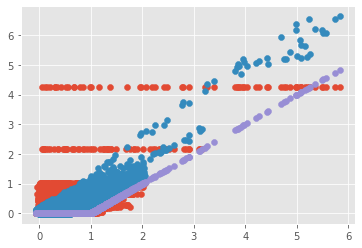

In [216]:
preds = model.predict(X).reshape(-1)
plt.scatter(X[:,0], ys)
plt.scatter(X[:,0], preds)
plt.scatter(X[:, 0], np.maximum(X[:, 0] - 1.0, 0))